<div class="alert alert-block alert-success" align=center>
    <h1>RANDOM FOREST</h1>
</div>

Come secondo modello, si analizza e si valuta la Random Forest.

Il motivo principale per cui la si è posta come secondo modello è che la Random Forest permette di individuare le feature più importanti con cui poter costruire il modello attraverso l'RFECV.

Infatti, una volta individuate tali feature, si è deciso di creare un altro dataset da poter utilizzare nei prossimi notebook in modo da avere il dataset il più pulito possibile e con solo l'informazione utile.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV  
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
def split(dataframe):
    
    # Si toglie la colonna da predire
    X = dataframe.drop(columns=['Sale_Price'], axis =1)

    # Si isola la colonna da predire
    y = dataframe['Sale_Price']

    X_train_80, X_test, y_train_80, y_test = train_test_split(X, y, test_size = 0.20, random_state = 3)
    
    return X_train_80, X_test, y_train_80, y_test

In [3]:
def divide(dataframe):
    
    # Si separano le feature dal prezzo
    X_train = dataframe.drop(columns = ['Sale_Price'], axis = 1)
    
    y_train = dataframe['Sale_Price']
    
    return X_train, y_train

Si importa il dataset sporco con outliers.

In [4]:
df = pd.read_csv('dataset_enc.csv')

In [5]:
X_train_80, X_test, y_train_80, y_test = split(df)

Si importa il training-set del dataset sporco ma senza outliers.

In [6]:
df_train_wo_out = pd.read_csv('training_wo_outliers.csv')

In [7]:
X_train_wo_out, y_train_wo_out = divide(df_train_wo_out)

Si importa il dataset pulito.

In [8]:
df_clean = pd.read_csv('dataset_pulito.csv')

In [9]:
X_clean_train_80, X_clean_test, y_clean_train_80, y_clean_test = split(df_clean)

Si importano il training-set e il test-set del dataset pulito ma senza outliers.

In [10]:
df_clean_train_wo_out = pd.read_csv('training_clean_wo_outliers.csv')

In [11]:
X_clean_train_wo_out, y_clean_train_wo_out = divide(df_clean_train_wo_out)

### Funzione che implementa il modello base

- Il numero di alberi è 1.

In [12]:
def rf_base(X_train, X_test, y_train, y_test):
    
    # Array per salvarsi i risultati ottenuti
    MAE = []
    
    # Creazione modello
    model = RandomForestRegressor(n_estimators = 1, random_state = 3)
    model.fit(X_train, y_train)

    # Calcolo dell'errore assoluto sul test-set
    y_pred_test = model.predict(X_test)
    MAE = mean_absolute_error(y_true = y_test, y_pred = y_pred_test)
    
    # Grafico y reali vs y predette
    plt.scatter(y_test, y_pred_test)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # Calcolo dello score
    score = r2_score(y_test, y_pred_test)

    return MAE, score

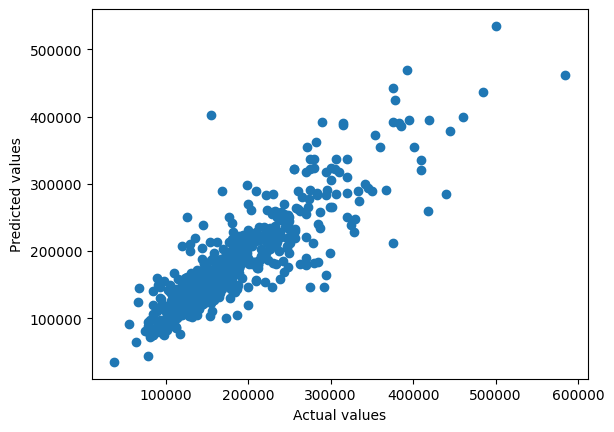

In [13]:
MAE_test_base_rf, score = rf_base(X_train_80, X_test, y_train_80, y_test)

In [14]:
print("Errore: ", MAE_test_base_rf)
print("Score: ", score)

Errore:  24448.15699658703
Score:  0.7554850243209983


Si prova il modello base anche sugli altri dataset per individuare degi eventuali miglioramenti nell'errore e nello score.

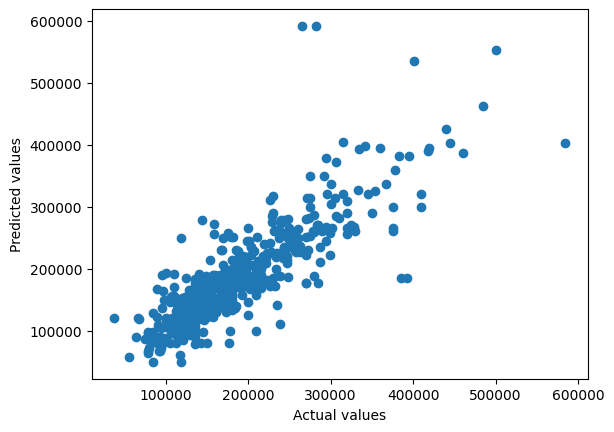

In [15]:
MAE_test_base_rf_wo_out, score_wo_out = rf_base(X_train_wo_out, X_test, y_train_wo_out, y_test)

In [16]:
print("Errore: ", MAE_test_base_rf_wo_out)
print("Score: ", score_wo_out)

Errore:  25979.290102389077
Score:  0.6945771576881908


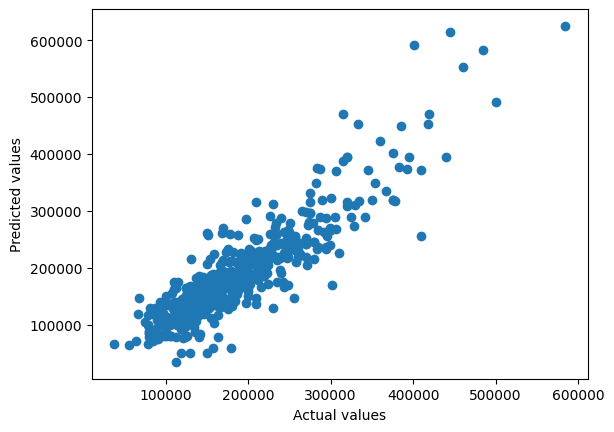

In [17]:
MAE_test_clean_base_rf, score_clean = rf_base(X_clean_train_80, X_clean_test, y_clean_train_80, y_clean_test)

In [18]:
print("Errore: ", MAE_test_clean_base_rf)
print("Score: ", score_clean)

Errore:  25297.926621160408
Score:  0.7661651899683674


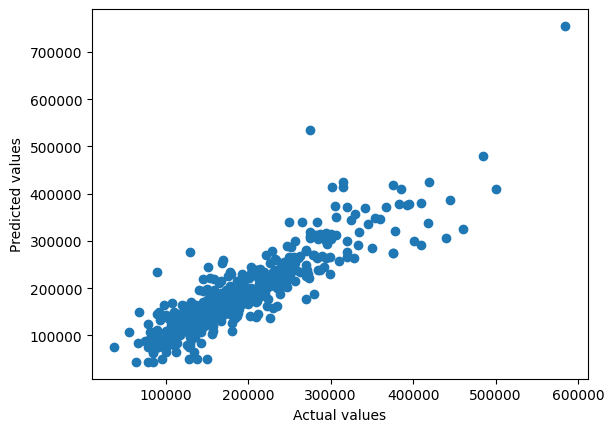

In [19]:
MAE_test_clean_base_rf_wo_out, score_clean_wo_out = rf_base(X_clean_train_wo_out, X_clean_test, y_clean_train_wo_out, y_clean_test)

In [20]:
print("Errore: ", MAE_test_clean_base_rf_wo_out)
print("Score: ", score_clean_wo_out)

Errore:  23240.196245733787
Score:  0.7803946635500322


<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>

Da un'analisi sullo score, si nota che il dataset l'allenamento del modello sul dataset pulito (con e senza outliers) è migliore rispetto all'allenamento sul dataset sporco con gli outliers, sebbene l'errore del dataset iniziale con outliers sia più basso dell'errore del dataset pulito con outliers.

Il modello emergente (con miglior score e miglior errore) è il dataset pulito senza oultiers, sinonimo che la fase di pulizia ha giovato sulle prestazioni del modello!

Si vuole testare se è possibile migliorare questi risultati e per questo motivo si cerca di individuare il numero migliore di alberi e di feature che il modello deve avere a disposizione per ottenere un ancora più corretta predizione.

Di conseguenza, qui di seguito verrà utilizzato il dataset pulito con gli outliers, a cui successivamente verranno tolti.

➤ Per valutare il miglior numero di alberi si utilizza la tecnica del Cross-Validation.

➤ Per valutare il miglior numero di feature ci si appoggia a RFECV, ovvero Recursive Feature Elimination Cross-Validation.

Si egue lo split per il Cross-Validation.

In [21]:
def split_cross(X_train, y_train):
    
    X_train_new, X_valid, y_train_new, y_valid  = train_test_split(X_train, y_train, test_size = 0.25, random_state = 3)
    
    return X_train_new, X_valid, y_train_new, y_valid

In [22]:
X_clean_train_80_v, X_clean_valid, y_clean_train_80_v, y_clean_valid = split_cross(X_clean_train_80, y_clean_train_80)

### Funzione che implementa la ricerca del miglior numero di alberi per costituire la foresta

In [23]:
def cv_Trees(X_train, X_valid, X_test, y_train, y_valid, y_test, n_trees = 10):
    
    # Array per salvarsi i risultati ottenuti
    MAE = []
    MAE_plot = []
    boosts = range(1, n_trees)
    
    # ------------------------------------------------------------------
    
    # Ciclo for per vedere i cambiamenti dell'mae in base al parametro di regolarizzazione
    for i in boosts:
        
        # Creazione modello
        model =  RandomForestRegressor(n_estimators = i, random_state = 3)
        model.fit(X_train, y_train)
        
        # Calcolo dell'errore (mae) sul training-set
        y_pred_train = model.predict(X_train)
        MAE_train = mean_absolute_error(y_true = y_train, y_pred = y_pred_train)
        
        # Calcolo dell'errore (mae) sul valid-set
        y_pred_valid = model.predict(X_valid)
        MAE_valid = mean_absolute_error(y_true = y_valid, y_pred = y_pred_valid)
        
        # L'array mae contiene elementi che a loro volta sono array di 3 elementi: 
        # parametro di regolarizzazione, errore sul train e errore sul test
        MAE_plot += [[i, MAE_train, MAE_valid]]
        
    # ------------------------------------------------------------------
    
    # Si cerca l'errore migliore (il più piccolo)
    minimum_error = MAE_plot[0][2]
    best_n_trees = MAE_plot[0][0]
    
    for i in range(len(MAE_plot)):
        if(minimum_error > MAE_plot[i][2]):
            minimum_error = MAE_plot[i][2]
            best_n_trees = MAE_plot[i][0]

    # Si crea un nuovo modello con il parametro di regolarizzazione associato all'errore migliore
    best_model = RandomForestRegressor(n_estimators = best_n_trees)
    best_model.fit(X_train, y_train)
    
    # Calcolo dell'errore assoluto sul test-set
    y_pred_test = best_model.predict(X_test)
    MAE_test = mean_absolute_error(y_true = y_test, y_pred = y_pred_test)
    
    # L'array best_n_estimators contiene elementi che a loro volta sono array di 2 elementi: 
    # numero di vicini, errore assoluto sul test
    MAE = [best_n_trees, MAE_test]

    MAE_plot = np.array(MAE_plot)
    
    # Grafico y reali vs y predette
    plt.scatter(y_test, y_pred_test)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # Grafico
    fig, ax = plt.subplots()
    ax.plot(MAE_plot[:,0], MAE_plot[:,1], "x:", label = "Train")
    ax.plot(MAE_plot[:,0], MAE_plot[:,2], "s-", label = "Valid")
    plt.xlabel("Number of trees")
    plt.ylabel("MAE")
    ax.legend()
    ax.grid()

    # Calcolo dello score
    score = r2_score(y_test, y_pred_test)

    return MAE, score

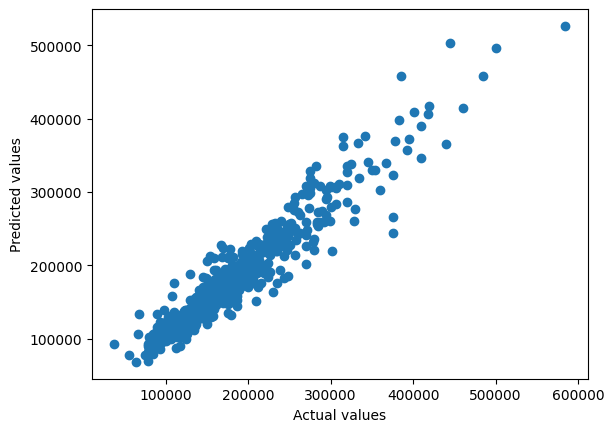

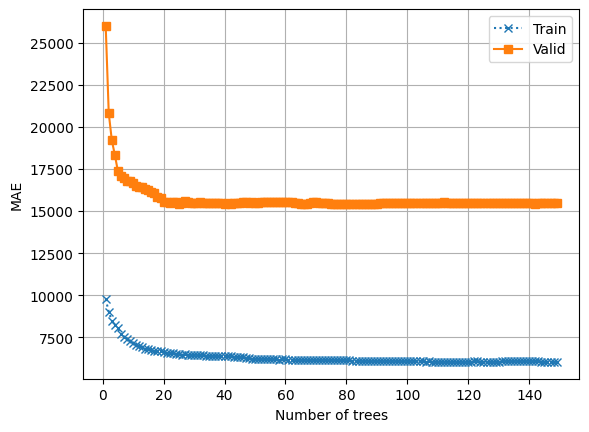

In [24]:
MAE_test_clean_trees, score_clean = cv_Trees(X_clean_train_80_v, X_clean_valid, X_clean_test, y_clean_train_80_v, y_clean_valid, y_clean_test, 150)

In [25]:
print("Errore: ", MAE_test_clean_trees)
print("Score: ", score_clean)
print("Numero di alberi: ", MAE_test_clean_trees[0])

Errore:  [25, 15568.707781569965]
Score:  0.9102811898815463
Numero di alberi:  25


### Funzione che implementa l'RFECV

In [26]:
X_clean_train_80.shape

(2344, 238)

In [27]:
def RFECV_Feature(X_train, y_train, n_trees):
    
    print(X_train.shape)
    # Creazione modello
    model = RandomForestRegressor(n_estimators = n_trees, random_state = 3)
    selector = RFECV(model, step = 2, scoring = "neg_mean_absolute_error")
    selector.fit(X_train, y_train)
    
    # Grafico delle feature
    n_scores = len(selector.cv_results_["mean_test_score"])
    plt.figure()
    plt.xlabel("Number of feature selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(
        range(1, n_scores + 1),
        selector.cv_results_["mean_test_score"],
        yerr=selector.cv_results_["std_test_score"],
    )
    plt.title("Recursive Feature Elimination \nwith Cross- Validation")
    plt.show()

    return selector.support_

(2344, 238)


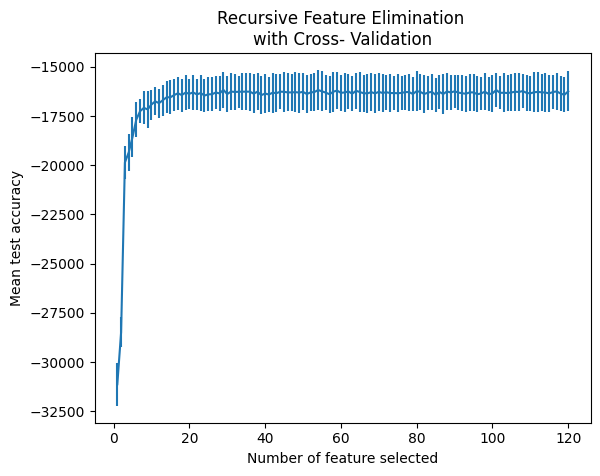

In [28]:
F_support = RFECV_Feature(X_clean_train_80, y_clean_train_80, MAE_test_clean_trees[0])

Il grafico mostra l'andamento dell'errore calcolato secondo il `mean absolute error` in base al numero di feature considerate.

Prima di valutare nuovamente l'errore sul modello è necessario modificare la dimensione dei dataframe su cui esso verrà calcolato.

In [29]:
def reduct_dimensions(X, support):
    
    # Array di supporto
    no_names = []
    
    # Se il valore nel supporto del selector è True significa che la feature è stata ritenuta importante dal RFE
    for i in range(len(support)):
        if (support[i] == False):
            no_names.append(X.columns[i])
            
    X = X.drop(columns = no_names, axis = 1)
    
    return X

In [30]:
X_clean_bf_train_80 = reduct_dimensions(X_clean_train_80, F_support)
X_clean_bf_train_wo_out = reduct_dimensions(X_clean_train_wo_out, F_support)
X_clean_bf_test = reduct_dimensions(X_clean_test, F_support)

In [31]:
print("La nuova dimensione del training-set pulito con gli outliers è: ", X_clean_bf_train_80.shape)
print("La nuova dimensione del training-set pulito senza gli outliers è: ", X_clean_bf_train_wo_out.shape)
print("La nuova dimensione del test-set è: ", X_clean_bf_test.shape)

La nuova dimensione del training-set pulito con gli outliers è:  (2344, 56)
La nuova dimensione del training-set pulito senza gli outliers è:  (2320, 56)
La nuova dimensione del test-set è:  (586, 56)


Ora si visualizzano i nomi delle feature scelte dall'algoritmo.

In [32]:
X_clean_bf_train_80.columns

Index(['Lot_Frontage', 'Lot_Area', 'Overall_Qual', 'Overall_Cond',
       'Year_Built', 'Year_Remod_Add', 'Mas_Vnr_Area', 'Exter_Qual',
       'Exter_Cond', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'Bsmt_Unf_SF', 'Total_Bsmt_SF',
       'Heating_QC', 'First_Flr_SF', 'Second_Flr_SF', 'Bedroom_AbvGr',
       'Kitchen_Qual', 'TotRms_AbvGrd', 'Fireplaces', 'Fireplace_Qu',
       'Garage_Area', 'Garage_Cond', 'Wood_Deck_SF', 'Mo_Sold', 'Year_Sold',
       'Bsmt_Baths', 'Baths', 'Total_SF_Floors', 'Porch_Area',
       'Mean_Price_Neigh', 'MS_SubClass_One_Story_1945_and_Older',
       'MS_Zoning_Residential_Low_Density', 'Lot_Shape_Regular',
       'Land_Contour_HLS', 'Lot_Config_Corner', 'Lot_Config_Inside',
       'Land_Slope_Gtl', 'Roof_Style_Gable', 'Exterior_1st_Wd Sdng',
       'Exterior_2nd_MetalSd', 'Exterior_2nd_VinylSd', 'Mas_Vnr_Type_Stone',
       'Foundation_CBlock', 'Central_Air_N', 'Garage_Type_Attchd',
       'Garage_Finish_RFn', 'Pav

Si può notare che tra le feature scelte sono presenti alcune delle feature che sono state modificate precedentemente: ad esempio, la feature `Overall_Qual` e `Overall_Cond` sono delle scale di qualità che si sono trasformate in scale numeriche, proprio per facilitare, oltre agli altri modelli, soprattutto gli alberi di decisione nel scegliere la soglia dei diversi nodi interni.

Si possono notare anche delle feature che si sono aggiunte, come `Bsmt_Baths`, `Baths`, `Total_SF_Floors` e `Porch_Area`.

Questo va a confermare che la pulizia è risultata fondamentale per la buona riuscita e predizione del modello in esame in questo notebook.

### Funzione che implementa la Random Forest con:
- Il miglior numero di alberi individuato;
- Il miglior numero di feature individuato.

In [33]:
def best_trees_feature(X_train, X_test, y_train, y_test, n_trees):
    
    # Si construisce una nuova random forest sul nuovo training-set con le feature più importanti
    model = RandomForestRegressor(n_estimators = n_trees, random_state = 3)
    model.fit(X_train, y_train)
    
    # Calcolo dell'errore assoluto sul test-set
    y_pred_test = model.predict(X_test)
    MAE = mean_absolute_error(y_true = y_test, y_pred = y_pred_test)
    
    # Tabella differenze tra le y predette e quelle reali
    diff_y = pd.DataFrame({'Actual Value' : y_test, 'Predicted Value' : y_pred_test, 'Difference' : abs(y_test - y_pred_test)})
    
    # Grafico y reali vs y predette
    plt.scatter(y_test, y_pred_test)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # Calcolo dello score
    score = r2_score(y_test, y_pred_test)    
    
    return MAE, score, diff_y

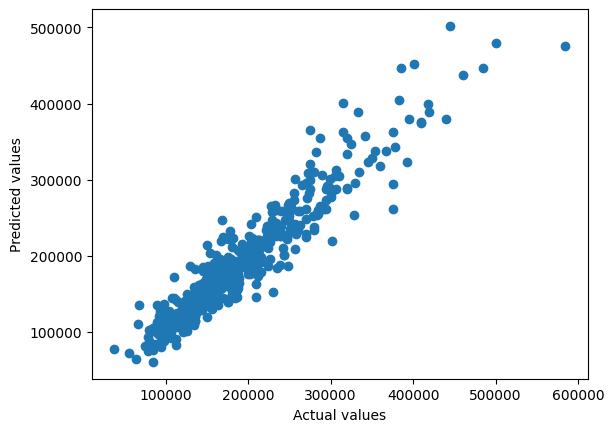

In [34]:
MAE_test, score, dataframe_diff = best_trees_feature(X_clean_bf_train_80, X_clean_bf_test, y_clean_train_80, y_clean_test, MAE_test_clean_trees[0])

In [35]:
print("Errore: ", MAE_test)
print("Score: ", score)

Errore:  15989.912150170649
Score:  0.9050605757881103


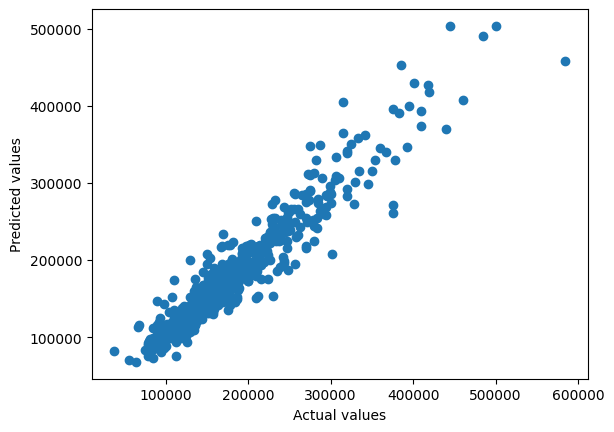

In [36]:
MAE_test_clean, score_clean, dataframe_diff_clean = best_trees_feature(X_clean_bf_train_wo_out, X_clean_bf_test, y_clean_train_wo_out, y_clean_test, MAE_test_clean_trees[0])

In [37]:
print("Errore: ", MAE_test_clean)
print("Score: ", score_clean)

Errore:  15740.316496018202
Score:  0.9059594279223329


<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>

La ricerca del miglior numero di alberi e di feature hanno portato ad un gran miglioramento nell'accuratezza delle predizioni che sul dataset pulito sono passate da circa 75% al circa 90%. 

Per uno scarto quasi esiguo, il dataset migliore si conferma il dataset pulito senza outliers, il quale è riuscito ad abbassare l'errore da circa 23.000 dollari a 15.700 dollari!

In [38]:
dataframe_confronto = dataframe_diff

<div class="alert alert-block alert-warning">
<b>Considerazioni finali</b>
</div>

Da questo notebook risulta che il tuning dei parametri sia stato efficace sul miglioramento delle prestazioni del modello, di fatti si riduce di molto l'errore e di aumenta notevolmente lo score.

Il modello migliore risulta essere il dataset pulito senza outliers in entrambi i modelli costruiti; ciò va a favore del lavoro di pulizia delle feature effettuato prima dell'allenamento del modello stesso.

Ora si trasformano questi nuovi dataframe i file csv.

In [39]:
df_clean_bf_train_80 = pd.concat([X_clean_bf_train_80, y_clean_train_80], axis = 1)

Si verifica la dimensione.

In [40]:
df_clean_bf_train_80.shape

(2344, 57)

Le feature risultano 57 e non 56 perchè si è aggiunto anche il valore da predire, ovvero `Sale_Price`.

In [41]:
df_clean_bf_train_80.to_csv(r'df_train_RFECV.csv', index = False)

Ora si procede anche con il training-set senza outliers.

In [42]:
df_clean_bf_train_wo_out = pd.concat([X_clean_bf_train_wo_out, y_clean_train_wo_out], axis = 1)

Si verifica la dimensione.

In [43]:
df_clean_bf_train_wo_out.shape

(2320, 57)

In [44]:
df_clean_bf_train_wo_out.to_csv(r'df_train_wo_out_RFECV.csv', index = False)

Infine si conclude con il test-set.

In [45]:
df_clean_bf_test = pd.concat([X_clean_bf_test, y_clean_test], axis = 1)

Si verifica la dimensione.

In [46]:
df_clean_bf_test.shape

(586, 57)

In [47]:
df_clean_bf_test.to_csv(r'df_test_RFECV.csv', index = False)

Come annunciato, Ora si crea un file csv per poi fare il confronto con i diversi modelli analizzati.

In [48]:
dataframe_confronto = pd.concat([X_clean_bf_test, dataframe_confronto], axis = 1)
dataframe_confronto.to_csv(r'df_confronto_RF.csv', index = False)